<a href="https://colab.research.google.com/github/FitriRamadhania/klasifikasi_gambar/blob/main/tgsDeepLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ============================
# 1. Import Necessary Libraries
# ============================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import torch.nn.functional as F

# ============================
# 2. Load and Transform Data
# ============================
from google.colab import drive
drive.mount('/content/drive')

# Ganti dengan path datasetmu di Google Drive
data_dir = '/content/drive/MyDrive/Semester_6/Deep_Learning/sunscreen'

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

dataset = ImageFolder(root=data_dir, transform=transform)

# ============================
# 3. Placing Data into a DataFrame
# ============================
df = pd.DataFrame(dataset.samples, columns=['Path', 'Label'])
df['Class'] = df['Label'].apply(lambda x: dataset.classes[x])
print(df.head())


Mounted at /content/drive
                                                Path  Label           Class
0  /content/drive/MyDrive/Semester_6/Deep_Learnin...      0  sunscreen body
1  /content/drive/MyDrive/Semester_6/Deep_Learnin...      0  sunscreen body
2  /content/drive/MyDrive/Semester_6/Deep_Learnin...      0  sunscreen body
3  /content/drive/MyDrive/Semester_6/Deep_Learnin...      0  sunscreen body
4  /content/drive/MyDrive/Semester_6/Deep_Learnin...      0  sunscreen body


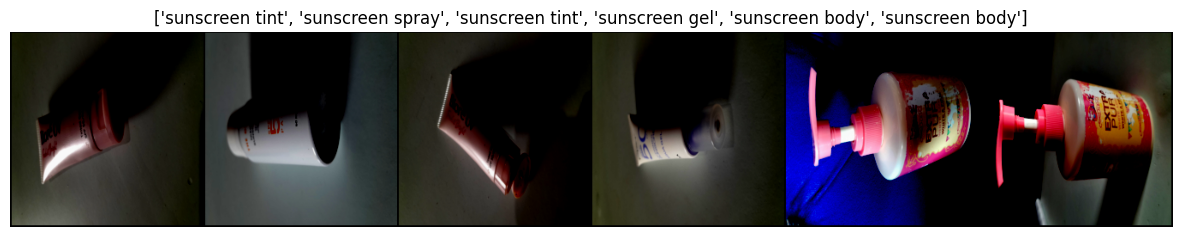

In [ ]:
# ============================
# 4. Visualizing images from the dataset
# ============================
def imshow_batch(dataset, n=6):
    loader = DataLoader(dataset, batch_size=n, shuffle=True)
    imgs, labels = next(iter(loader))
    grid = make_grid(imgs, nrow=n)
    plt.figure(figsize=(15,5))
    plt.imshow(np.transpose(grid, (1,2,0)))
    plt.title([dataset.classes[i] for i in labels])
    plt.axis('off')
    plt.show()

imshow_batch(dataset)

# ============================
# 5. Computing Error Rate Analysis
# ============================
# Ini akan dilakukan setelah prediksi model dengan confusion matrix


In [ ]:
# ============================
# 6. Data Preprocessing (Splitting)
# ============================
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [ ]:
# ============================
# 7. Training the model (Custom CNN or VGG16)
# ============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Option 1: Custom CNN
class CustomCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3)
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(64 * 54 * 54, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# Option 2: VGG16
def get_model(model_type="custom"):
    if model_type == "vgg":
        model = models.vgg16(pretrained=True)
        for param in model.features.parameters():
            param.requires_grad = False
        model.classifier[6] = nn.Linear(4096, 4)
    else:
        model = CustomCNN()
    return model.to(device)

model = get_model(model_type="vgg")  # Ubah ke "custom" jika ingin pakai CustomCNN

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
num_epochs = 50
train_loss, val_loss = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss.append(running_loss / len(train_loader))

    model.eval()
    running_vloss = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            vloss = criterion(outputs, labels)
            running_vloss += vloss.item()

    val_loss.append(running_vloss / len(val_loader))
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss[-1]:.4f} | Val Loss: {val_loss[-1]:.4f}")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 155MB/s]


Epoch 1/50 | Train Loss: 0.5392 | Val Loss: 0.5134
Epoch 2/50 | Train Loss: 0.1270 | Val Loss: 0.1278
Epoch 3/50 | Train Loss: 0.0668 | Val Loss: 0.3116
Epoch 4/50 | Train Loss: 0.1502 | Val Loss: 1.6162
Epoch 5/50 | Train Loss: 1.3328 | Val Loss: 0.9464
Epoch 6/50 | Train Loss: 0.3243 | Val Loss: 1.9161
Epoch 7/50 | Train Loss: 0.1409 | Val Loss: 0.3900
Epoch 8/50 | Train Loss: 0.2385 | Val Loss: 0.9639
Epoch 9/50 | Train Loss: 0.0522 | Val Loss: 0.5492
Epoch 10/50 | Train Loss: 0.3748 | Val Loss: 0.9222
Epoch 11/50 | Train Loss: 0.3201 | Val Loss: 1.2050
Epoch 12/50 | Train Loss: 0.3622 | Val Loss: 2.5526
Epoch 13/50 | Train Loss: 0.8979 | Val Loss: 1.5870
Epoch 14/50 | Train Loss: 0.5798 | Val Loss: 1.6056
Epoch 15/50 | Train Loss: 0.4795 | Val Loss: 1.9956
Epoch 16/50 | Train Loss: 0.1348 | Val Loss: 1.9736
Epoch 17/50 | Train Loss: 2.1313 | Val Loss: 6.2849
Epoch 18/50 | Train Loss: 0.3734 | Val Loss: 6.6659
Epoch 19/50 | Train Loss: 0.4906 | Val Loss: 3.0726
Epoch 20/50 | Train L

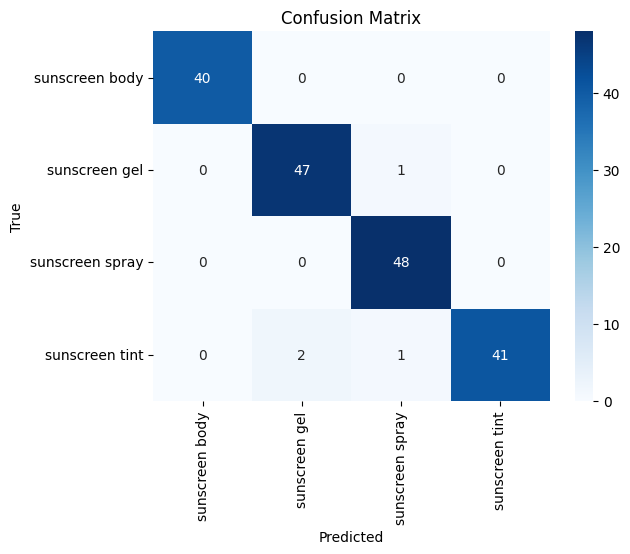

                 precision    recall  f1-score   support

 sunscreen body       1.00      1.00      1.00        40
  sunscreen gel       0.96      0.98      0.97        48
sunscreen spray       0.96      1.00      0.98        48
 sunscreen tint       1.00      0.93      0.96        44

       accuracy                           0.98       180
      macro avg       0.98      0.98      0.98       180
   weighted avg       0.98      0.98      0.98       180



In [ ]:
# ============================
# 8. Model Evaluation (Confusion Matrix)
# ============================
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=dataset.classes, yticklabels=dataset.classes, cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title("Confusion Matrix")
plt.show()

print(classification_report(all_labels, all_preds, target_names=dataset.classes))


In [9]:
# ============================
# 9. Making Predictions on the Test Data
# ============================
def predict_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_tensor = transform(image).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        output = model(image_tensor)
        _, pred = torch.max(output, 1)
    print("Predicted Class:", dataset.classes[pred.item()])

# predict_image("/content/drive/MyDrive/Semester_6/Deep_Learning/sunscreen.jpg")


In [7]:
from PIL import Image
from torchvision import transforms

# Path ke gambar
img_path = "/content/drive/MyDrive/Semester_6/Deep_Learning/sunscreen_spray.jpeg"

# Transformasi sesuai modelmu
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # atau ukuran sesuai model
    transforms.ToTensor(),
])

# Load gambar dan ubah ke tensor
img = Image.open(img_path).convert('RGB')
img_tensor = transform(img)

# Generate Grad-CAM
heatmap = generate_gradcam(img_tensor)

# Visualisasi
img_np = img_tensor.permute(1, 2, 0).cpu().numpy()
img_np -= img_np.min()
img_np /= img_np.max()

plt.imshow(img_np)
plt.imshow(heatmap, cmap='jet', alpha=0.5)
plt.title("Grad-CAM: sunscreen_spray.jpeg")
plt.axis('off')
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Semester_6/Deep_Learning/sunscreen_spray.jpeg'

In [6]:
import os

# Cek isi folder tempat kamu simpan dataset
folder_path = "/content/drive/MyDrive/Semester_6/Deep_Learning/sunscreen"

# List semua file di folder
file_list = os.listdir(folder_path)

print("Isi folder sunscreen:")
for file in file_list:
    print(file)


Isi folder sunscreen:
sunscreen_spray.jpeg
sunscreen_gel.jpeg
sunscreen_body.jpeg
sunscreen_tint.jpeg
.ipynb_checkpoints
